# Предсказание ухода сотрудников

## Этап 1

### Импорт библиотек, загрузка данных, разведочный анализ

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [3]:
os.chdir('/content/Drive/My Drive/azamadoleg')

In [4]:
df_general = pd.read_csv('general_data.csv')
df_general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [5]:
df_employee_survey = pd.read_csv('employee_survey_data.csv')
df_employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [6]:
df_manager_survey = pd.read_csv('manager_survey_data.csv')
df_manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [7]:
# объединим df_general, df_employee_survey, df_manager_survey
df = pd.merge(df_general, df_employee_survey, how='inner', on='EmployeeID')
df = pd.merge(df, df_manager_survey, how='inner', on='EmployeeID')
df.shape # посмотрим размер получившегося набора данных

(4410, 29)

In [8]:
df.info() # получим информацию о типах данных и количестве значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

В столбцах 'NumCompaniesWorked', 'TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance' некоторые из значений пропущены, заполним их пока -1, более аккуратная обработка пропусков будет ниже. Выбрана -1, а не 0, так как в поле 'TotalWorkingYears' имеются настоящие нулевые значения.

In [9]:
df = df.fillna(-1) # заполнение пропусков минус единицей

In [10]:
import seaborn as sns
sns.set()

In [11]:
col_list = ['Age','Attrition','BusinessTravel','DistanceFromHome',
                  'Education', 'EducationField','Gender', 'JobLevel', 'JobRole',
                   'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
                   'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
                   'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
                   'YearsWithCurrManager']
len(col_list)

19

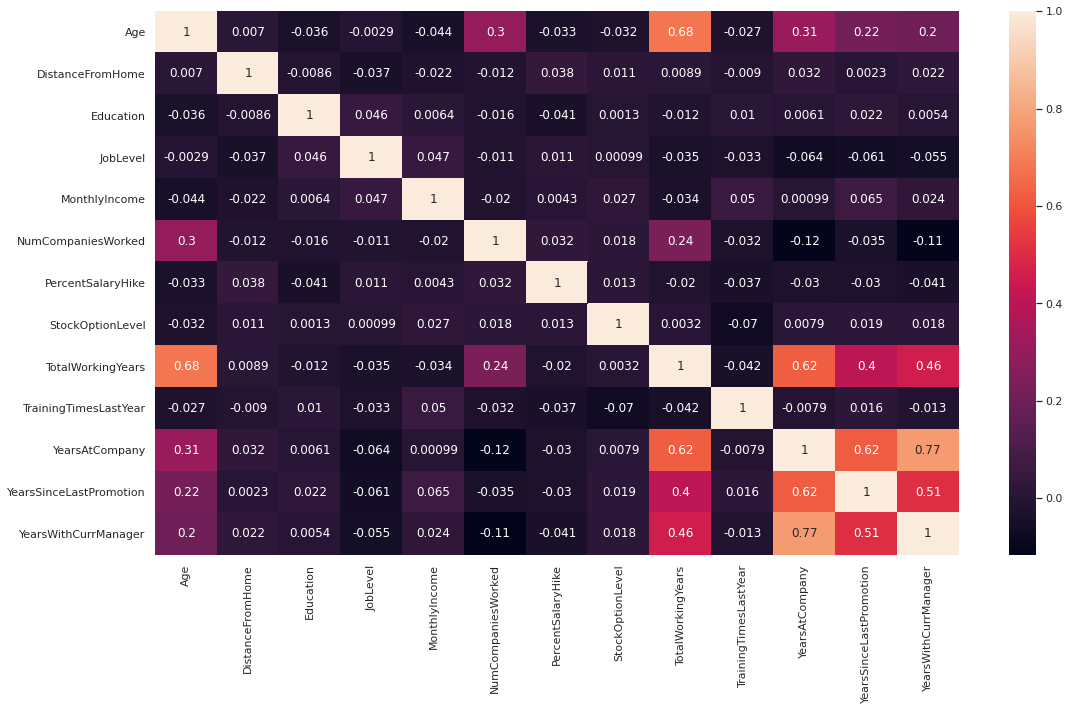

In [12]:
correlations = df[col_list].corr()
plt.figure(figsize=(18,10))
sns.heatmap(correlations, annot = True)
plt.show()

In [13]:
text_columns = list(df.describe(include=['O']).columns) 
text_columns # признаки, имеющие текстовые значения

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18']

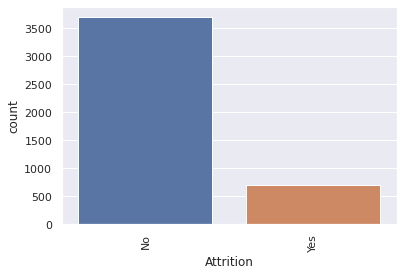

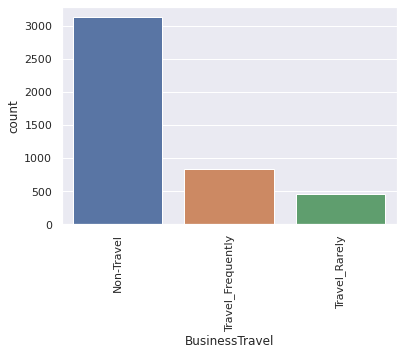

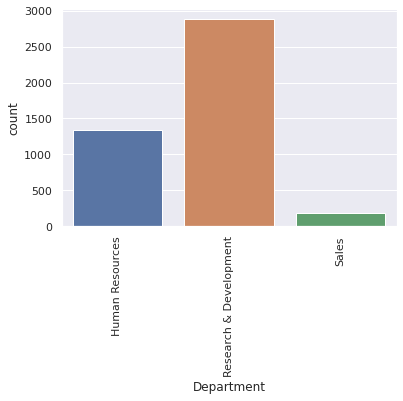

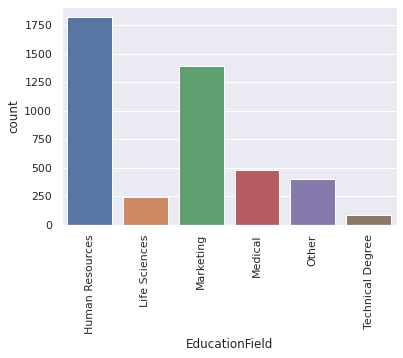

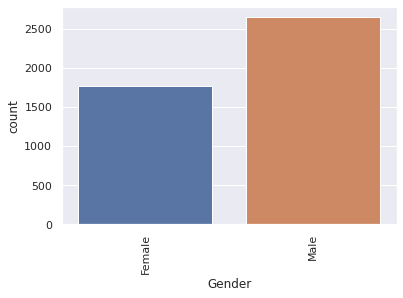

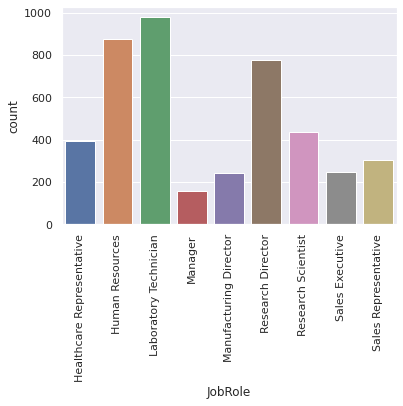

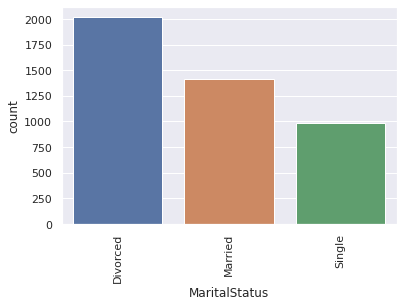

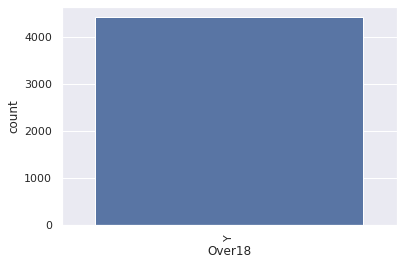

In [14]:
for col in text_columns:
    p = sns.countplot(x=col, data=df)
    p.set_xticklabels(np.unique(df.loc[:, col]), rotation=90)
    plt.show()

По диаграммам можно сделать выводы:
1. столбец Over18 заполнен единственным значением -> неинформативен
2. ни для одного признака нет значения с очень низким сount -> для этих признаков точно нет выбросов
3. BusinessTravel - порядковый признак, все остальные - категориальные
4. Соотношение классов примерно 1 к 5, поэтому нельзя сказать, что выборка является несбалансированной

### Предобработка признаков

#### Обработка категориальных признаков

In [15]:
categorical_columns = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Over18']

In [16]:
df = pd.get_dummies(df, columns=categorical_columns) # применим наивное(one-hot) кодирование

'BusinessTravel' определим как порядковый признак

In [17]:
df['BusinessTravel'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

'Attrition', 'Gender' - бинарные признаки. Чтобы не создавать лишние столбцы:

In [18]:
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

#### Удаление неинформативных данных

In [19]:
print(df['EmployeeCount'].value_counts())
print(df['Over18_Y'].value_counts())
print(df['StandardHours'].value_counts())
print(df['EmployeeID'].value_counts())

1    4410
Name: EmployeeCount, dtype: int64
1    4410
Name: Over18_Y, dtype: int64
8    4410
Name: StandardHours, dtype: int64
2047    1
2632    1
2620    1
573     1
2624    1
       ..
1302    1
3347    1
1298    1
3343    1
2049    1
Name: EmployeeID, Length: 4410, dtype: int64


Столбцы EmployeeCount, Over18_Y, StandardHours заполнены только одним значением, поэтому они неинформативны. Поле EmployeeID является искусственным и не несет никакой информации о сотрудниках. Удалим эти столбцы.

In [20]:
df = df.drop(['EmployeeCount', 'Over18_Y', 'StandardHours', 'EmployeeID'], axis=1)

In [21]:
df.head() # посмотрим на данные после обработки признаков

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,0,1,6,2,0,1,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,31,1,2,10,1,0,1,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,32,0,2,17,4,1,4,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,38,0,0,2,5,1,3,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,32,0,1,10,1,1,1,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


#### Заполнение пропусков в данных

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [23]:
col_with_miss = ['NumCompaniesWorked', 'TotalWorkingYears', 
                 'JobSatisfaction', 'EnvironmentSatisfaction', 
                 'WorkLifeBalance'] # столбцы с пропусками
filled = df.drop(col_with_miss+['Attrition'], axis=1) 
# в filled хранятся столбцы без пропусков
for col in col_with_miss:
    index_mask = df[col] != -1    # маска строк, в которых не было пропущенных значений в столбце col
    X = filled[index_mask]        # используем эти строки для предсказания пропущенных
    y = df[col][index_mask]       # значения из столбца с пропусками
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    rfc = RandomForestClassifier(n_estimators=30)
    rfc.fit(X_train, y_train)     # обучим RandomForest 
    print(col,': ','macro f1_score=', f1_score(y_test, rfc.predict(X_test), average='macro'), sep='')
    y_pred = rfc.predict(filled[~index_mask])   # предсказание пропущенных значений
    df.loc[~index_mask, col] = y_pred   # заполнение пропусков предсказанными данными

NumCompaniesWorked: macro f1_score=0.9664929213106708
TotalWorkingYears: macro f1_score=0.96814114475223
JobSatisfaction: macro f1_score=0.9343036218210705
EnvironmentSatisfaction: macro f1_score=0.9651718407823762
WorkLifeBalance: macro f1_score=0.9736075855838259


#### Удаление выбросов

In [24]:
df.columns # посмотрим на список признаков, чтобы выбрать кандидатов для проверки на наличие выбросов

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'Gender', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', '

Из анализа диаграмм: для признаков 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus' выбросов нет.

In [25]:
cols_to_check = ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
                 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
                 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 
                 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 
                 'JobInvolvement', 'PerformanceRating']

In [26]:
df[cols_to_check].describe() # Посмотрим на квантили, минимальные и максимальные значения у cols_to_check

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,2.063946,65029.312925,2.693197,15.209524,0.793878,11.279592,2.799320,7.008163,2.187755,4.123129,2.721769,2.729478,2.761224,2.729932,3.153741
std,9.133301,8.105026,1.023933,1.106689,47068.888559,2.497442,3.659108,0.851883,7.779017,1.288978,6.125135,3.221699,3.567327,1.092834,1.102202,0.706316,0.711400,0.360742
min,18.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,2.000000,2.000000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,7.000000,3.000000,2.000000,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,14.000000,4.000000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


Метод среднеквадратичного отклонения, метод интерквартильного интервала могут немного смутить значения max в 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', YearsSinceLastPromotion', 'YearsWithCurrManager'; однако эти значения больше похожи на действительные выбросы(Майкл Джордан в баскетболе), чем на входную ошибку или искаженные данные, поэтому принято решение не изменять их.

#### Нормализация данных

In [27]:
X = df.drop(['Attrition'], axis=1).to_numpy()
y = df['Attrition'].to_numpy()

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_scaled = scaler.fit_transform(X) # нормализация в [0, 1]

### Классификация 

In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pickle

In [30]:
# разобъём выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

#### Применение метода опорных векторов

In [ ]:
from sklearn.svm import SVC # SVM-классификатор 
from sklearn.svm import LinearSVC # линейный метод опорных векторов

In [ ]:
# разобъём выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

In [ ]:
linear_svc = GridSearchCV(LinearSVC(random_state=42), 
                          {'C': [10, 100, 1000, 3000], 'max_iter': [5000, 10000]},
                          scoring = 'f1', cv=5) # модели сравниваем по f1
# больше C -> больше штраф за объекты, попадающие на "территорию" др.класса
# max_iter: максимальное кол-во итераций для алгоритма

In [ ]:
linear_svc.fit(X_train, y_train) # используя grid search, найдём параметры

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=42, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10, 100, 1000, 3000], 'max_iter': [5000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
print("params from grid search:", linear_svc.best_params_)
print("Linear SVM on CV:", linear_svc.best_score_)
print("on test:", f1_score(linear_svc.best_estimator_.predict(X_test), y_test))

params from grid search: {'C': 3000, 'max_iter': 5000}
Linear SVM on CV: 0.30771914461401967
on test: 0.13095238095238096


Результаты совсем плохие, попробуем для SVM различные варианты ядер(kernel trick)

In [ ]:
params_svc = {'kernel': ['poly', 'rbf', 'sigmoid'], # тип ядра для SVM
              'C': np.arange(2000, 4000, 200)}
grid_svc = GridSearchCV(SVC(gamma='auto', random_state=42), 
                        params_svc, scoring='f1', cv=5)

In [ ]:
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800]),
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
svc_best = SVC( # лучший классификатор согласно grid_svc
    kernel=grid_svc.best_params_['kernel'],
    C=grid_svc.best_params_['C'],
    random_state=42)

In [ ]:
%%time
svc_best.fit(X_train, y_train)

CPU times: user 453 ms, sys: 4 ms, total: 457 ms
Wall time: 460 ms


SVC(C=3400, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
print("params from grid search:", grid_svc.best_params_)
print("SVM with trick on CV:", grid_svc.best_score_)
print("on test:", f1_score(grid_svc.best_estimator_.predict(X_test), y_test))

params from grid search: {'C': 3400, 'kernel': 'poly'}
SVM with trick on CV: 0.9116747434317013
on test: 0.967741935483871


Полиномиальная модель показала наилучшую оценку скользящего контроля: 91.17%. На тестовых данных получен f1-score: 96.77%. Таким образом, то, с чем совсем не смог справиться SVM с линейным ядром, SVM с полиномиальным смог отделить спокойно.

In [ ]:
with open("svc_model.pkl", 'wb') as file:
    pickle.dump(svc_best, file)

#### Применение композиций алгоритмов

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=
                    {'n_estimators': [350, 400],'max_depth': [12, 14]}, 
                    cv=5, scoring='f1')
# сетка гиперпараметров для случайного леса
# n_estimators = количество решающих деревьев
# max_depth = максимальная глубина дерева

In [ ]:
grid_rf.fit(X_train, y_train) # поиск параметров для случайного леса

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
rf_best = RandomForestClassifier(
    max_depth=grid_rf.best_params_['max_depth'],
    n_estimators=grid_rf.best_params_['n_estimators'],
    random_state=42
) # случайный лес с найденными grid search гиперпараметрами

In [ ]:
%%time
rf_best.fit(X_train, y_train)

CPU times: user 1.65 s, sys: 17 ms, total: 1.66 s
Wall time: 1.67 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print("params from grid search:", grid_rf.best_params_)
print("Random Forest on CV:", grid_rf.best_score_)
y_pred = rf_best.predict(X_test)
print(classification_report(y_pred, y_test))

params from grid search: {'max_depth': 14, 'n_estimators': 350}
Random Forest on CV: 0.9130364256359259
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       757
           1       0.89      1.00      0.94       125

    accuracy                           0.98       882
   macro avg       0.94      0.99      0.96       882
weighted avg       0.98      0.98      0.98       882



In [ ]:
with open("rf_model.pkl", 'wb') as file:
    pickle.dump(rf_best, file)

In [ ]:
grid_boost = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    scoring='f1', param_grid={'learning_rate': [0.1, 0.05],
                              'n_estimators': [350, 400], 
                              'max_depth': [12, 14]})
# сетка гиперпараметров для случайного леса
# learning rate = гиперпараметр для аккуратного движения в пространстве

In [ ]:
grid_boost.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [ ]:
boost_best = GradientBoostingClassifier(
    learning_rate=grid_boost.best_params_['learning_rate'],
    n_estimators=grid_boost.best_params_['n_estimators'],
    max_depth=grid_boost.best_params_['max_depth'],
    random_state=42
) # градиентный бустинг с найденными grid search гиперпараметрами

In [ ]:
%%time
boost_best.fit(X_train, y_train)

CPU times: user 5.37 s, sys: 997 µs, total: 5.37 s
Wall time: 5.38 s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print("params from grid search:", grid_boost.best_params_)
print("Gradient boosting on CV:", grid_boost.best_score_)
y_pred = boost_best.predict(X_test)
print(classification_report(y_pred, y_test))

params from grid search: {'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 350}
Gradient boosting on CV: 0.9286232328093051
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       744
           1       0.96      0.98      0.97       138

    accuracy                           0.99       882
   macro avg       0.98      0.99      0.98       882
weighted avg       0.99      0.99      0.99       882



In [ ]:
with open("boosting_model.pkl", 'wb') as file:
    pickle.dump(boost_best, file)

#### Метод логистической регрессии

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=200),
                  {'C': [1+10*i for i in range(11)],
                   'solver': ['lbfgs', 'liblinear'], 
                   'penalty': ['l2', 'none', 'l1'],
                   'max_iter': [100, 200, 300] 
                   },
                   scoring='f1', cv=5)

In [33]:
%%time
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:5

CPU times: user 45.8 s, sys: 29 s, total: 1min 14s
Wall time: 39.5 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l2', 'none', 'l1'],
                         'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', ver

CPU times: user 45.8 s, sys: 29 s, total: 1min 14s

Wall time: 39.5 s

In [34]:
print("params from LogisticRegression:", lr.best_params_)
print("LogisticRegression on CV:", lr.best_score_)
print("on test:", f1_score(lr.best_estimator_.predict(X_test), y_test))

params from LogisticRegression: {'C': 1, 'max_iter': 100, 'penalty': 'none', 'solver': 'lbfgs'}
LogisticRegression on CV: 0.3026273569309039
on test: 0.2645502645502646


In [35]:
column_names = [x for x in df if x != 'Attrition']  # названия признаков

In [36]:
coefs = lr.best_estimator_.coef_[0]
influence = [(column_names[i], coefs[i]) for i in np.argsort(-np.abs(coefs))]
# influence - список: (название признака, его влияние на результат)  
print('Факторы, способствующие уходу сотрудников')
print([el[0] for el in influence if el[1] >= 0][:5])
print('Факторы, способствующие лояльности сотрудников')
print([el[0] for el in influence if el[1] < 0][:5]) 

Факторы, способствующие уходу сотрудников
['YearsSinceLastPromotion', 'BusinessTravel', 'NumCompaniesWorked', 'MaritalStatus_Single', 'EducationField_Human Resources']
Факторы, способствующие лояльности сотрудников
['TotalWorkingYears', 'YearsWithCurrManager', 'Age', 'JobSatisfaction', 'TrainingTimesLastYear']


Проинтерпретируем результаты. 

Сотрудники склонны к уходу из компании, когда:

1.   они долго ждут повышения
2.   часто бывают в командировках
3.   работали во многих компаниях
4.   не состоят в браке
5.   учились на HR

Люди скорее всего останутся в компании на следующий год, если они:

1.   имеют большой трудовой стаж
2.   долгое время работают с текущим менеджером
3.   солидного возраста
4.   довольны работой
5.   проходили обучение в течение последнего года



In [37]:
with open("logreg_model.pkl", 'wb') as file:
    pickle.dump(lr.best_estimator_, file)

Характеристики компьютера: Intel(R) Xeon(R) CPU 2.30GHz, RAM 12.72 GB